# Библиотеки

In [1]:
import librosa
import pandas as pd 
import numpy as np
import numpy.matlib
import os
import platform
import glob
import seaborn as sns
import IPython.display as ipd
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics 
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, classification_report, cohen_kappa_score
from sklearn.svm import SVC
import time
import seaborn as sn
from tqdm import tqdm

In [4]:
Ravdess='./data/ravdess-emotional-speech-audio/audio_speech_actors_01-24/'

ravdess_directory_list=os.listdir(Ravdess)

file_emotion=[]
file_path=[]

for dir in ravdess_directory_list:
    actor=os.listdir(Ravdess + dir)
    for file in actor:
        part=file.split('.')[0]
        part=part.split('-')
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
emotion_df=pd.DataFrame(file_emotion, columns=['Emotions'])

path_df=pd.DataFrame(file_path, columns=['Path'])
Ravdess_df=pd.concat([emotion_df,path_df],axis=1)

Ravdess_df.Emotions.replace({1:'Neutral', 2:'Calm', 3:'Happy', 4:'Sad', 5:'Angry', 6:'Fearful', 7:'Disgust', 8:'Surprised'}, inplace=True)
Ravdess_df.tail()

,Emotions,Path
1435,Surprised,./data/ravdess-emotional-speech-audio/audio_sp...
1436,Surprised,./data/ravdess-emotional-speech-audio/audio_sp...
1437,Surprised,./data/ravdess-emotional-speech-audio/audio_sp...
1438,Surprised,./data/ravdess-emotional-speech-audio/audio_sp...
1439,Surprised,./data/ravdess-emotional-speech-audio/audio_sp...


## Averaged vector of MFCCs for signal expressing anger

In [5]:
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fear',
  '07':'disgust',
  '08':'surprised'
}

actors={
  '01':'1',
  '02':'2',
  '03':'3',
  '04':'4',
  '05':'5',
  '06':'6',
  '07':'7',
  '08':'8',
  '09':'9',
  '10':'10',
  '11':'11',
  '12':'12',
  '13':'13',
  '14':'14',
  '15':'15',
  '16':'16',
  '17':'17',
  '18':'18',
  '19':'19',
  '20':'20',
  '21':'21',
  '22':'22',
  '23':'23',
  '24':'24'
}

#defined tess emotions to test on TESS dataset only
tess_emotions=['angry','disgust','fear','ps','happy','sad']

#defined RAVDESS emotions to test on RAVDESS dataset only
ravdess_emotions=['neutral','calm','angry', 'happy','disgust','sad','fear','surprised']

observed_emotions = ['sad','angry','happy','disgust','surprised','neutral','calm','fear']

## Feature extraction </p>
Using librosa package we can extract the MFCC features. This function loads the file give the file path and after resampling and computing MFCC features, returns the features. We have selected the no. of MFCCs as 40.

In [7]:
def extract_feature(file_name, mfcc_flag):
    '''
    Performing the calculation of supra-segment features 
    based on MFCC to obtain a characteristic vector.
    
    Output:
    The resulting mean MFCC and standard deviation of MFCC 
    provides a measure of the average squared deviation of 
    each MFCC feature across time line.
    '''
    X, sample_rate = librosa.load(file_name)
    if mfcc_flag:
        mfccs = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T
        mean_mfcc = np.mean(mfccs, axis=0)
        # sd_mfcc = np.std(mfccs,axis=0)        
        return mean_mfcc#,sd_mfcc
    else:
        return None

### Validation feature vector

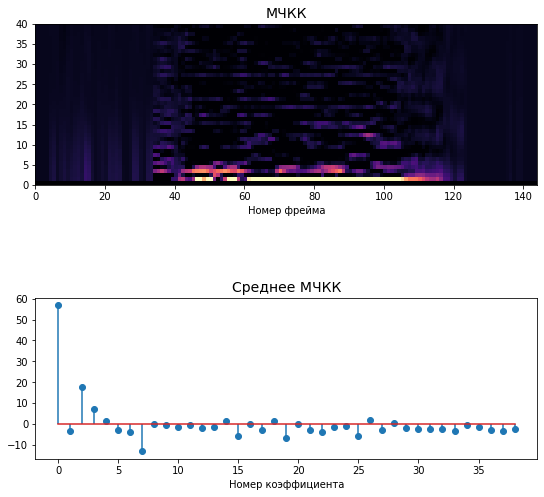

In [8]:
file_name = "data/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-02-01.wav"
mfcc = True
X, sample_rate = librosa.load(file_name)

mfccs = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T
mean_mfcc  = extract_feature(file_name, mfcc)

fig,ax=plt.subplots(figsize=(9,8))
plt.subplot(2,1,1)
plt.pcolor(mfccs.T, cmap='magma',shading='flat')
plt.xlabel('Номер фрейма')
plt.title('МЧКК',fontsize=14)
plt.clim((-5,90))
plt.subplot(2,1,2)
plt.stem(mean_mfcc[1:])
plt.xlabel('Номер коэффициента')
plt.title('Среднее МЧКК',fontsize=14)
plt.subplots_adjust(hspace=0.7)

In [9]:
def dataset_options():
    # choose datasets
    ravdess = True
    tess = False
    ravdess_speech = False
    ravdess_song = False
    data = {'ravdess':ravdess, 'ravdess_speech':ravdess_speech, 'ravdess_song':ravdess_song, 'tess':tess}
    print(data)
    return data

### Функция загрузки данных

In [10]:
def load_data(): 
    X,y,ID=[],[],[]
    
    # feature to extract
    mfcc = True
    
    data = dataset_options()
    paths = []
    if data['ravdess']:
        if platform.system() == "Windows":
            paths.append("data/ravdess-emotional-speech-audio/audio_speech_actors_01-24/**/*.wav")
        else:    
            paths.append("data/ravdess-emotional-speech-audio/audio_speech_actors_01-24/**/*.wav")
    elif data['ravdess_speech']:
        paths.append("./data/ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_*/*.wav")
    elif data['ravdess_song']:
        paths.append("./data/ravdess-emotional-song-audio/audio_song_actors_01-24/Actor_*/*.wav")

    for path in paths:
        for file in tqdm(glob.glob(path)):
            file_name=os.path.basename(file)
            splited_file_name = file_name.split("-")
            emotion=emotions[splited_file_name[2]] #to get emotion according to filename. dictionary emotions is defined above.
            if emotion not in observed_emotions: #options observed_emotions - RAVDESS and TESS, ravdess_emotions for RAVDESS only
                continue
            actor = np.array(actors[splited_file_name[6].split(".")[0]])
            feature = extract_feature(file, mfcc)            
            X.append(feature)
            y.append(emotion)
            ID.append(actor)
    if data['tess']:
        for file in glob.glob("./data/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/*AF_*/*.wav"):
            file_name=os.path.basename(file)
            emotion=file_name.split("_")[2][:-4] #split and remove .wav
            if emotion == 'ps':
                emotion = 'surprised'
            if emotion not in observed_emotions: #options observed_emotions - RAVDESS and TESS, ravdess_emotions for RAVDESS only
                continue
            feature=extract_feature(file, mfcc)
            X.append(feature)
            y.append(emotion)
    return {"X":X,"y":y,"ID":ID}

In [11]:
start_time = time.time()

Trial_dict = load_data()

print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))
X = pd.DataFrame(Trial_dict["X"])
y = pd.DataFrame(Trial_dict["y"])
ID = pd.DataFrame(Trial_dict["ID"])

## Standartize data
X = (X-X.mean())/X.std()

# Storing ravdess and tess data to avoid loading again
X.to_csv('data/feature_vector_based_mean_mfcc_2023-07-26.csv') 
y.to_csv('data/y_labels_2023-07-26.csv') 
ID.to_csv('data/IDs_2023-07-26.csv') 

print("X.shape = ",X.shape)
print("y.shape = ",y.shape)
print("ID.shape = ",ID.shape)

{'ravdess': True, 'ravdess_speech': False, 'ravdess_song': False, 'tess': False}


100%|██████████| 1440/1440 [05:22<00:00,  4.46it/s]

--- Data loaded. Loading time: 322.8798532485962 seconds ---
X.shape =  (1440, 40)
y.shape =  (1440, 1)
ID.shape =  (1440, 1)


In [12]:
starting_time = time.time()

# data = pd.read_csv('./data/characteristic_vector_using_mfcc_and_mean_square_deviation_20230722.csv')
X = pd.read_csv('data/feature_vector_based_mean_mfcc_2023-07-26.csv') 
X = X.drop('Unnamed: 0',axis=1)
y = pd.read_csv('data/y_labels_2023-07-26.csv') 
y = y.drop('Unnamed: 0',axis=1)
ID= pd.read_csv('data/IDs_2023-07-26.csv') 
ID = ID.drop('Unnamed: 0',axis=1)

print("data loaded in " + str(time.time()-starting_time) + "ms")

print(X.head())
print("X.shape = ", X.shape)
print("X.columns = ",X.columns)

data loaded in 0.022524356842041016ms
          0         1         2         3         4         5         6  \
0 -1.072979  0.380243  0.503993  0.541567  0.880266  0.651826  0.475373   
1 -1.025567  0.419444  0.314939  1.014027  0.989545  0.576570  0.750134   
2 -1.011729  0.574108  0.467737  0.684913  0.610154  0.735168  0.666932   
3 -0.948316  0.441064  0.675443  0.641687  0.795600  0.999141  0.742920   
4 -1.362001  0.862036  0.684995  0.897280  0.904002  0.879039  0.434597   

          7         8         9  ...        30        31        32        33  \
0  0.979666 -0.833990 -0.332004  ... -0.826022 -1.548762 -1.109963 -1.462239   
1  0.611529 -1.008899  0.073978  ... -0.659243 -1.695706 -0.954883 -1.627865   
2  0.558521 -0.683125 -0.541791  ... -0.747774 -1.543129 -1.005146 -1.473122   
3  0.270733 -0.692966 -0.438520  ... -1.005135 -1.544544 -1.194653 -1.763699   
4  0.903385 -0.606415 -0.778402  ... -0.888693 -1.181395 -0.849412 -1.634691   

         34        35        3

In [13]:
ID['0'].unique()    # actors

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24], dtype=int64)

In [14]:
#custom K-Fold implementation

def combine_df_group(X, y, ID, group_members):
    X_k_fold= dict()
    y_k_fold= dict()
    for k, members in group_members.items():
        mathced_dataframes = []  
        fold_X = pd.DataFrame()
        fold_y = pd.DataFrame()

        for actor_ID in members:
            inds = ID[ID['0']==actor_ID].index.tolist()
            fold_X = pd.concat([fold_X, X.loc[inds,:]])
            fold_y = pd.concat([fold_y, y.loc[inds,:]])
        X_k_fold[k] = fold_X
        y_k_fold[k] = fold_y
    return X_k_fold,y_k_fold

In [16]:
group_members={
  '0': {2, 5, 14, 15, 16},
  '1': {3, 6, 7, 13, 18},
  '2': {10, 11, 12, 19, 20},
  '3': {8, 17, 21, 23, 24},
  '4': {1, 4, 9, 22} 
}


X_k_folds, y_k_folds = combine_df_group(X, y, ID, group_members)
print(len(X_k_folds))
# print(X_k_folds['4'])
# print(y_k_folds['4'])

5


## Unweighted average recall for multiclass classification model evaluation

In [17]:
def calculate_unweighted_average_recall(y_true, y_pred):
    '''
    calculates the unweighted average recall across all the classes present 
    in the true labels (y_true) 
    and predicted labels (y_pred) using the confusion matrix.
    '''
    cm = confusion_matrix(y_true, y_pred)
    num_classes = len(cm)
    recalls = []
    for i in range(num_classes):
        true_positives = cm[i, i]
        actual_positives = sum(cm[i, :])
        recall = true_positives / actual_positives
        recalls.append(recall)
    average_recall = sum(recalls) / num_classes
    return average_recall

## SVM with Linear kernel

In [18]:
# Train & evaluate cycle
y_pred = []
y_true = []

# for k in tqdm(range(len(X_k_folds.keys()))):
for k in tqdm(X_k_folds.keys()):    
    # Prepare dataset
    X_train = pd.DataFrame()
    y_train = pd.DataFrame()    
    # for i in range(len(X_k_folds.keys())):
    for i in X_k_folds.keys():        
        if (i!=k):
            X_train = pd.concat([X_train, X_k_folds[i]])
            y_train = pd.concat([y_train, y_k_folds[i]])
        else:
            X_test = X_k_folds[i]
            y_test = y_k_folds[i]
    # Train classifier
    # starting_time = time.time()
    SVM = SVC(kernel = 'linear')
    SVM.fit(X_train.values, y_train.values.ravel())
    # print(f"Trained model in {str(time.time() - starting_time)} ms ")
    y_pred_k_fold = SVM.predict(X_test.values)

    y_pred = np.concatenate((y_pred, y_pred_k_fold), axis=None)
    y_true = np.concatenate((y_true, y_test.values), axis=None)

UAR = calculate_unweighted_average_recall(y_true, y_pred)
print(f'UAR = {UAR:.3f}')

100%|██████████| 5/5 [00:01<00:00,  4.10it/s]

UAR = 0.340


## Results and confusion matrix

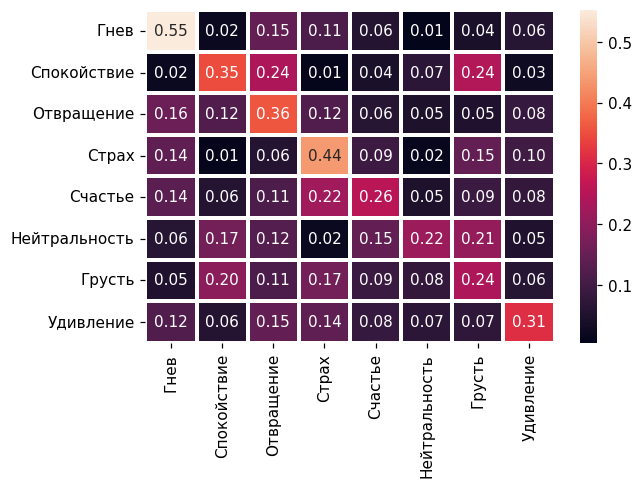

In [19]:
labels = np.unique(y_test)
labels_translated = np.array(['Гнев', 
                              'Спокойствие', 
                              'Отвращение', 
                              'Страх', 
                              'Счастье', 
                              'Нейтральность', 
                              'Грусть', 
                              'Удивление'])
cm = confusion_matrix(y_true, y_pred, normalize='true', labels=labels)

df_cm_4 = pd.DataFrame(cm,columns = labels_translated, index = labels_translated)
fig,ax = plt.subplots(dpi = 110)
sn.heatmap(df_cm_4, annot=True, fmt='.2f',linewidth=1.5)
plt.show()
image_name = f'Doc/figures/confusion_matrix.jpg'
fig.savefig(image_name, format='jpg', dpi=200, bbox_inches='tight', pad_inches = 0.2) 